In [3]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from script.plotDisplay import plotDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
mlp_model = ctypes.CDLL("modele/mlp/target/release/libmlp_classification.so")

# Définir les types d'arguments et de retour des fonctions C
PROGRESS_CALLBACK = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_double)
mlp_model.mlpInit.argtypes = [ctypes.POINTER(ctypes.c_size_t), ctypes.c_size_t, ctypes.c_double]
mlp_model.mlpInit.restype = ctypes.c_void_p

mlp_model.mlpTrain.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_bool,
    PROGRESS_CALLBACK,
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.c_char_p  
]
mlp_model.mlpTrain.restype = None


mlp_model.mlpPredict.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_double)
]
mlp_model.mlpPredict.restype = None

mlp_model.mlpFree.argtypes = [ctypes.c_void_p]
mlp_model.mlpFree.restype = None


# First test case

In [5]:
parameter = np.array([2, 1], dtype=np.uintp)
learning_rate = 0.1
epochs = 1000000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "simpleTestCase".encode('utf-8')

# tensorboard_dir = "./log/"
parameter_ptr = parameter.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, parameter.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0]
], dtype=np.float64)

y_train = np.array([
    [1.0],
    [-1.0],
    [1.0]
], dtype=np.float64)

print(f'vecteur {X_train}')
print(f'vecteur {X_train.shape}')

layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.5741589755072645, -0.5468664915568371]], bias: [0.0], input_size: 2, output_size: 1 }]
vecteur [[0. 0.]
 [0. 1.]
 [1. 0.]]
vecteur (3, 2)


In [6]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    batch_size,
    classification,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [0. 0.] , predictions = [0.99996547]
Sample [0. 1.] , predictions = [-0.99997624]
Sample [1. 0.] , predictions = [0.99999891]
ndim = 1


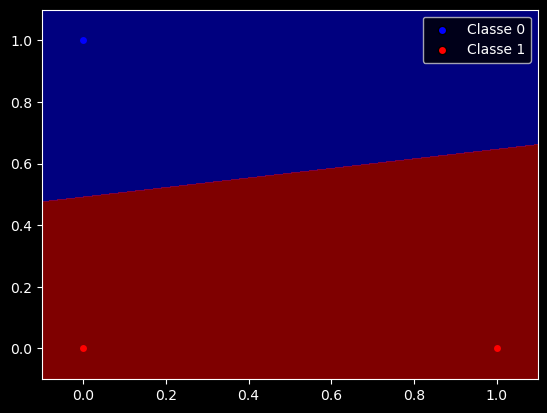

In [7]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)


plotDisplay(X_train, y_train, nn, mlp_model)


mlp_model.mlpFree(nn)

# Xor test case

In [8]:
X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
], dtype=np.float64)

y_train = np.array([
    [-1.0],
    [1.0],
    [1.0],
    [-1.0]
], dtype=np.float64)

neurons_size = np.array([X_train.shape[1], 3, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.01
epochs = 1000000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "xorTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)


print(f'vecteur {X_train}')
print(f'vecteur {y_train}')

vecteur [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
vecteur [[-1.]
 [ 1.]
 [ 1.]
 [-1.]]
layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.7524727986937663, -0.4487801785651797], [-0.8346758815124455, -0.9001256394510713], [0.43059447952580054, -0.23243677570734533]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }, NeuralMatrix { matrix: [[-0.6359421844678912, -0.5668920579275256, 0.4879432100378689]], bias: [0.0], input_size: 3, output_size: 1 }]


In [9]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    batch_size,
    classification, 
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [0. 0.] , predictions = [-0.99920828]
Sample [0. 1.] , predictions = [0.34236233]
Sample [1. 0.] , predictions = [0.34236233]
Sample [1. 1.] , predictions = [0.3423623]
ndim = 1


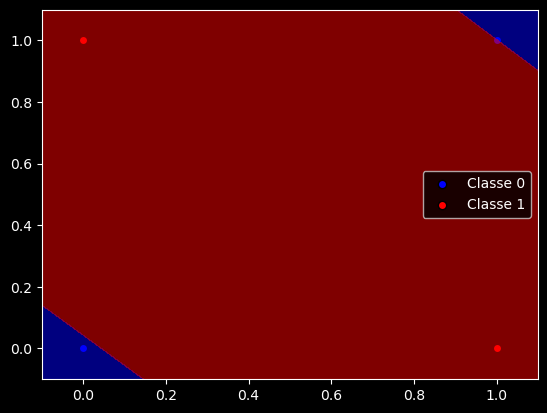

In [10]:
predictions = []
for k in range(len(X_train)):
    prediction = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    predictions.append(prediction.tolist())
    print("Sample", X_train[k], ", predictions =", prediction)


plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

# Multi class test

In [11]:
X_train = np.array([
    [1.0, 1.0],  # Classe A
    [5.0, 5.0],  # Classe B
    [0, 3.0] 
], dtype=np.float64)

y_train = np.array([
    [1.0, 0.0, 0.0],  # Classe A
    [0.0, 1.0, 0.0],  # Classe B
    [0.0, 0.0, 1.0]   # Classe C
], dtype=np.float64)

neurons_size = np.array([X_train.shape[1], y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.01
epochs = 1000000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "simpleMultiTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

print(f"shape : {X_train.shape}")
print(f"shape : {y_train.shape}")

shape : (3, 2)
shape : (3, 3)
layer : 1
neural matrix : [NeuralMatrix { matrix: [[-0.20226788439669052, -0.22021474262325436], [0.21813840382650396, -0.5301051566829247], [0.8423295445886367, -0.23458036553355965]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }]


In [12]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    batch_size,
    classification,  
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [1. 1.] , predictions = [0.99125853 0.00551706 0.00322442]
Sample [5. 5.] , predictions = [3.27066289e-03 9.96725444e-01 3.89292115e-06]
Sample [0. 3.] , predictions = [2.94054007e-03 7.82755552e-04 9.96276704e-01]
ndim = multi


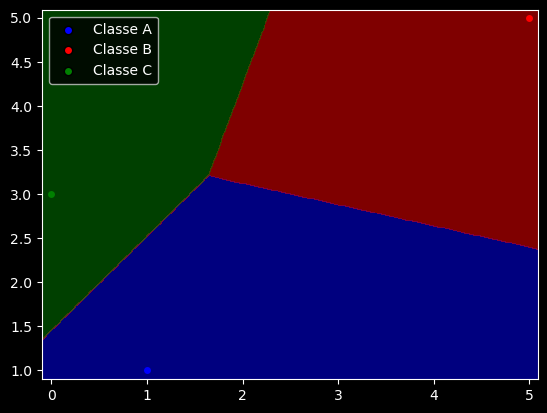

In [13]:
for k in range(len(X_train)):
    predictions = np.zeros(3, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)

plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

# Multi class 

In [14]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1.0, 0.0, 0.0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
                [0.0, 1.0, 0.0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
                [0.0, 0.0, 1.0] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
                [0, 0, 0] for p in X], dtype=np.float64)

X_train = X[[not np.all(arr == [0, 0, 0]) for arr in Y]]
y_train = Y[[not np.all(arr == [0, 0, 0]) for arr in Y]]

neurons_size = np.array([2, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.1
epochs = 100000
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "MultiTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)


# print(f"{X_train}")
print(f"shape : {X_train.shape}")
print(f"shape : {y_train.shape}")

shape : (411, 2)layer : 1

shape : (411, 3)
neural matrix : [NeuralMatrix { matrix: [[0.15505915000276094, 0.3453071885260268], [-0.4592071352868383, -0.6757317174431305], [0.6619854484843999, 0.15569969884821067]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }]


In [15]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

trainResult = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs, 
    1,
    True,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

ndim = multi


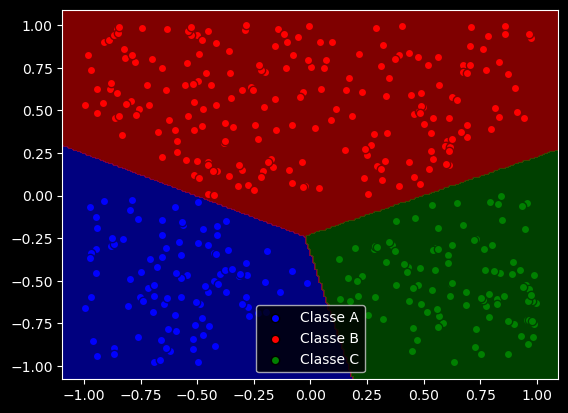

In [16]:
# for k in range(len(X_train)):
#     predictions = np.zeros(3, dtype=np.float64)
#     mlp_model.mlpPredict(
#         nn,
#         X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
#         X_train[k].size,
#         True,
#         predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
#     )
    # print("Sample", X_train[k], ", predictions =", predictions)

plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

## Cross entropy

In [17]:

X_train = np.random.random((500, 2)) * 2.0 - 1.0
y_train = np.array([[1.0] if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else [-1.0] for p in X_train], dtype=np.float64)

# X_train = np.random.random((500, 2)) * 2.0 - 1.0
# y_train = np.array([[1.0] if p[0] * p[0] + p[1] * p[1] <= 0.5 else [-1.0] for p in X_train], dtype=np.float64)

print(f"X_train : {X_train[:10]}")
print(f"X_train : {y_train[:10]}")

neurons_size = np.array([X_train.shape[1], 4, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.1
epochs = 100000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "CrossEntropy".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)


# print(f"{X_train}")
print(f"shape : {X_train.shape}")
print(f"shape : {y_train.shape}")

X_train : [[ 0.29443277  0.90224386]
 [-0.05704282 -0.72444023]
 [-0.23561313  0.23091994]
 [-0.0123505  -0.28826696]
 [-0.14853067 -0.63315238]
 [ 0.36862652  0.62748608]
 [-0.21542349 -0.25989229]
 [ 0.79790213  0.09022296]
 [-0.89598397  0.83731225]
 [ 0.6761676  -0.86510402]]
X_train : [[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]]
shape : (500, 2)
shape : (500, 1)
layer : 2
neural matrix : [NeuralMatrix { matrix: [[-0.2428754708694454, -0.8303637834700637], [0.18772089349895404, 0.3038793944093783], [-0.5764465183136505, -0.18858753052627897], [-0.7667817628360587, -0.2254439154483081]], bias: [0.0, 0.0, 0.0, 0.0], input_size: 2, output_size: 4 }, NeuralMatrix { matrix: [[-0.8806992882682492, 0.8700279278208942, 0.8554279036634753, -0.5817089245382276]], bias: [0.0], input_size: 4, output_size: 1 }]


In [18]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs, 
    batch_size,
    classification,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Accuracy : 0.988
ndim = 1


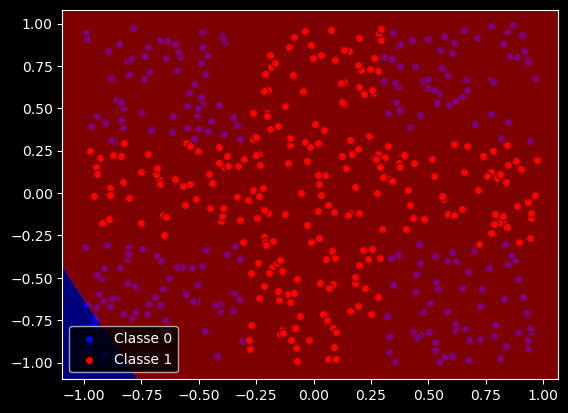

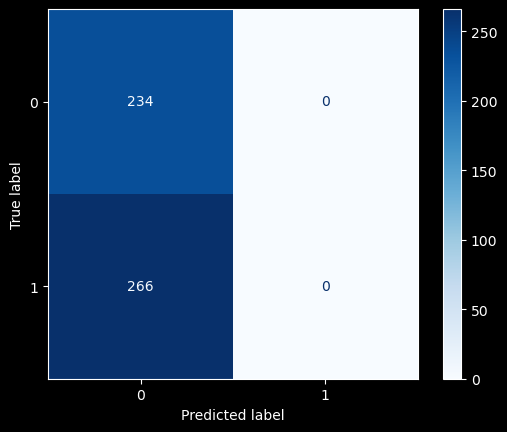

In [19]:

accurate = 0
for k in range(len(X_train)):
    predictions = np.zeros(3, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    if np.argmax(predictions) == np.argmax(y_train[k]):
        accurate += 1
    # print("Sample", X_train[k], ", predictions =", predictions)

print(f"Accuracy : {accurate / len(X_train)}")
plotDisplay(X_train, y_train, nn, mlp_model)

cm = confusion_matrix(np.argmax(X_train, axis=1), np.argmax(y_train, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


mlp_model.mlpFree(nn)

# Cross multi class

In [20]:

X_train = np.random.random((1000, 2)) * 2.0 - 1.0
y_train = np.array([
    [1.0, 0.0, 0.0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else 
    [0.0, 1.0, 0.0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else 
    [0.0, 0.0, 1.0] 
    for p in X_train
])


neurons_size = np.array([X_train.shape[1], 4, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.1
epochs = 100000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
log_enable = False
log_tag = "crossLinearTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

# print(y_train[:10])
# print(X_train[:10])
# print(f"shape {X_train.shape}")
# print(f"shape {y_train.shape}")

# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='rbw')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.ylabel('X3')
# plt.title('Training Data Visualization')
# plt.show()


layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.43368918088783737, -0.9042289796357359], [0.6708870361509267, -0.624241240785405], [-0.05347876189741552, -0.6400162861531156], [0.3264852831919529, 0.004351867219031469]], bias: [0.0, 0.0, 0.0, 0.0], input_size: 2, output_size: 4 }, NeuralMatrix { matrix: [[-0.8396622863896637, 0.8212603283512658, -0.44504811663888955, -0.7807406759037829], [-0.21261359483149844, -0.13355050011098868, -0.34064835880071476, 0.9231361450528284], [0.5964962291809885, -0.9209870895894801, 0.9448673605412057, -0.1849711204234552]], bias: [0.0, 0.0, 0.0], input_size: 4, output_size: 3 }]


In [21]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs, 
    batch_size,
    True,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

ndim = multi


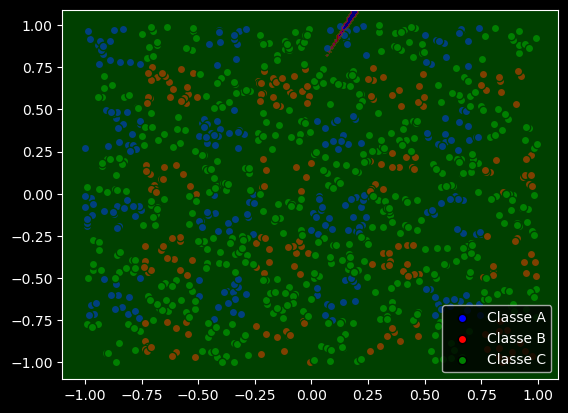

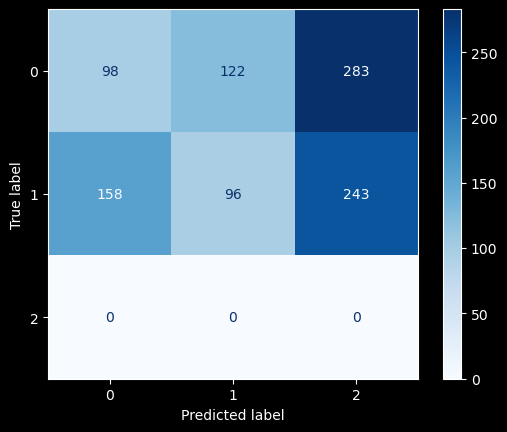

In [22]:
# for k in range(len(X_train)):
#     predictions = np.zeros(3, dtype=np.float64)
#     mlp_model.mlpPredict(
#         nn,
#         X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
#         X_train[k].size,
#         True,
#         predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
#     )
    # print("Sample", X_train[k], ", predictions =", predictions)

plotDisplay(X_train, y_train, nn, mlp_model)

cm = confusion_matrix(np.argmax(X_train, axis=1), np.argmax(y_train, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

mlp_model.mlpFree(nn)

# Simple linear test

In [23]:
neurons_size = np.array([1, 1], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000000
callback_interval = 1000
checkpoint_enable = False
callback_interval = 1000
log_enable = False
log_tag = "simpleLinearTestCase".encode('utf-8')
parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
], dtype=np.float64)

y_train = np.array([
    [-3.0],
    [2.0],
], dtype=np.float64)

layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.31189777166651433]], bias: [0.0], input_size: 1, output_size: 1 }]


In [24]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    1,
    False,
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [25]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)

# plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [-3.]
Sample [7.] , predictions = [2.]


# Linear test

In [26]:
neurons_size = np.array([1, 3, 1], dtype=np.uintp)
learning_rate = 0.01
epochs = 10000000
callback_interval = 10000
checkpoint_enable = False
callback_interval = 1000
log_enable = False
log_tag = "linearTestCase".encode('utf-8')
parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
    [9.0],
], dtype=np.float64)

y_train = np.array([
    [8.0],
    [2.0],
    [6.0],
], dtype=np.float64)

layer : 2
neural matrix : [NeuralMatrix { matrix: [[-0.7474723279164719], [-0.32411874208699], [0.15520580861914013]], bias: [0.0, 0.0, 0.0], input_size: 1, output_size: 3 }, NeuralMatrix { matrix: [[0.5774335925376226, 0.9579220409317157, 0.7061531370622456]], bias: [0.0], input_size: 3, output_size: 1 }]


In [27]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    16,
    False,
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/10000000 [00:00<?, ?it/s]

In [28]:
allPrediction = []
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    allPrediction.append(predictions)
    print("Sample", X_train[k], ", predictions =", predictions)

# plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [5.33333333]
Sample [7.] , predictions = [5.33333333]
Sample [9.] , predictions = [5.33333333]


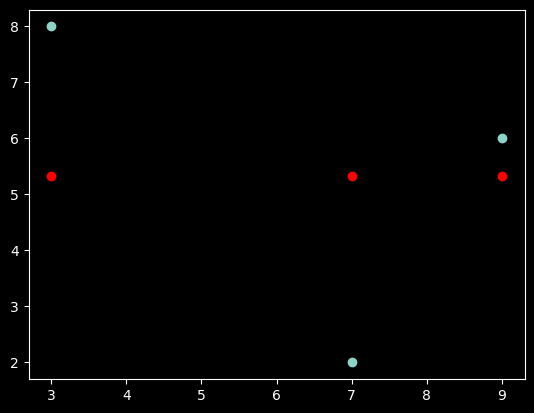

In [29]:
plt.scatter(X_train, y_train)
plt.scatter(X_train, allPrediction, c='red')
plt.show()